In [1]:
import sys
sys.path.append('../')

import jax
from jax import numpy as jp
import matplotlib.pyplot as plt
from IPython.display import HTML
from brax.io import model, html
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from src import networks
from utils import get_env_config, create_env
import pickle
import numpy as np

import flax.linen as nn
from brax.training import gradients, distribution, types, pmap
import functools
from jax import numpy as jnp
import seaborn as sns
import pandas as pd

In [2]:
RUN_FOLDER_PATH = '/n/fs/klips/JaxGCRL/runs/run_ant-main-batch256_s_1'
CKPT_NAME = '/step_11427840.pkl'

In [3]:
params = model.load_params(RUN_FOLDER_PATH + '/ckpt' + CKPT_NAME)
policy_params, encoders_params = params
sa_encoder_params, g_encoder_params = encoders_params['sa_encoder'], encoders_params['g_encoder']

In [4]:
args_path = RUN_FOLDER_PATH + '/args.pkl'

with open(args_path, "rb") as f:
    args = pickle.load(f)

config = get_env_config(args)

In [5]:
env = create_env(env_name=args.env_name, backend=args.backend)
obs_size = env.observation_size
action_size = env.action_size

In [6]:
# The SAEncoder, GoalEncoder, and Actor all use the same function. Output size for SA/Goal encoders should be representation size, and for Actor should be 2 * action_size.
# To keep parity with the existing architecture, by default we only use one residual block of depth 2, hence effectively not using the residual connections.
class Net(nn.Module):
    """
    MLP with residual connections: residual blocks have $block_size layers. Uses swish activation, optionally uses layernorm.
    """
    output_size: int
    width: int = 1024
    num_blocks: int = 4
    block_size: int = 2
    use_ln: bool = True
    @nn.compact
    def __call__(self, x):
        lecun_uniform = nn.initializers.variance_scaling(1/3, "fan_in", "uniform")
        normalize = nn.LayerNorm() if self.use_ln else (lambda x: x)
        
        # Start of net
        residual_stream = jnp.zeros((x.shape[0], self.width))
        
        # Main body
        for i in range(self.num_blocks):
            for j in range(self.block_size):
                x = nn.swish(normalize(nn.Dense(self.width, kernel_init=lecun_uniform)(x)))
            x += residual_stream
            residual_stream = x
                
        # Last layer mapping to representation dimension
        x = nn.Dense(self.output_size, kernel_init=lecun_uniform)(x)
        return x


In [7]:
def make_policy(actor, parametric_action_distribution, params, deterministic=False):
    def policy(obs, key_sample):
        obs = jnp.expand_dims(obs, 0)
        # print("obs shape", obs.shape)
        logits = actor.apply(params, obs)
        # print("logits shape", logits.shape)
        if deterministic:
            action = parametric_action_distribution.mode(logits)
        else:
            action = parametric_action_distribution.sample(logits, key_sample)
            action = action[0]
            # print("action shape", action.shape)
        extras = {}
        return action, extras
    return policy

In [8]:
# Network functions
block_size = 2 # Maybe make this a hyperparameter
num_blocks = max(1, args.n_hidden // block_size)
actor = Net(action_size * 2, args.h_dim, num_blocks, block_size, args.use_ln)
sa_net = Net(args.repr_dim, args.h_dim, num_blocks, block_size, args.use_ln)
g_net = Net(args.repr_dim, args.h_dim, num_blocks, block_size, args.use_ln)
parametric_action_distribution = distribution.NormalTanhDistribution(event_size=action_size) # Would like to replace this but it's annoying to.

inference_fn = make_policy(actor, parametric_action_distribution, policy_params)
# inference_fn = inference_fn(params[:1])

# crl_networks = networks.make_crl_networks(config, env, obs_size, action_size)

# inference_fn = networks.make_inference_fn(crl_networks)
# inference_fn = inference_fn(params[:2])

sa_encoder = lambda obs: sa_net.apply(sa_encoder_params, obs)
g_encoder = lambda obs: g_net.apply(g_encoder_params, obs)

In [9]:
NUM_EPISODES = 1

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

In [10]:
trajectories = []
rollouts = []
rewards = []

for episode in range(NUM_EPISODES):
    trajectory = []
    reward = []
    rng = jax.random.PRNGKey(seed=episode)
    state = jit_env_reset(rng=rng)
    # print(state.reward)
    for _ in range(1000):
        rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        # print(state.obs.shape)
        act, _ = jit_inference_fn(state.obs, act_rng)
        trajectory.append((state,act))
        reward.append(state.reward.item())
        state = jit_env_step(state, act)
    rewards.append(reward)
    trajectories.append(trajectory)

In [11]:
# HTML(html.render(env.sys.tree_replace({'opt.timestep': env.dt}), rollouts))
# html.save("ant-crl-main.html", env.sys.tree_replace({'opt.timestep': env.dt}), rollouts) 

In [12]:
TRAJECTORY_TO_DRAW = 0

raw_observations = np.array([state.obs for (state, _) in trajectories[TRAJECTORY_TO_DRAW]])
actions = np.array([act for (_, act) in trajectories[TRAJECTORY_TO_DRAW]])

observations = raw_observations[:, :obs_size]

encoded_sa = sa_encoder(jp.concatenate((observations[:, :-2], actions), axis = 1))
encoded_g = g_encoder(observations[:, -2:])
print("encoded sa", encoded_sa.shape)
print(encoded_g.shape)
# encoded_sag = jp.concatenate((encoded_sa, encoded_g[:1,:]), axis = 0)
# print("encoded-sag", encoded_sag.shape)

encoded sa (1000, 64)
(1000, 64)


In [13]:
scaled_encodings = StandardScaler().fit_transform(encoded_sa)
features = PCA(n_components=2).fit_transform(scaled_encodings)

total reward 101.0


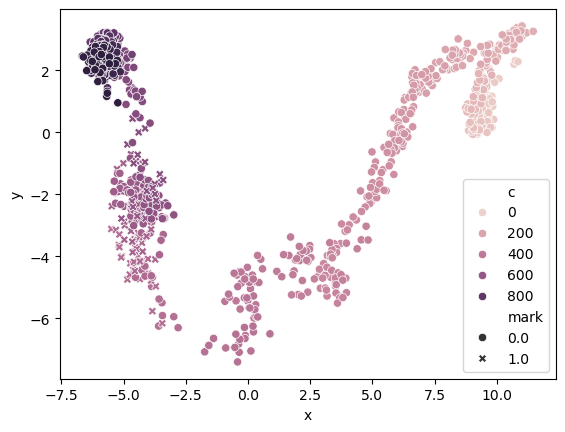

In [14]:
# Make Figure
x = features[:,0]
y = features[:,1]
c = np.arange(0, 1000)
mark = rewards[TRAJECTORY_TO_DRAW]
# print(mark)
df = pd.DataFrame({'x':x,'y':y,'c':c, 'mark':mark})
scatter_plot = sns.scatterplot(data = df, x='x', y='y', hue='c', style='mark')

scatter_fig = scatter_plot.get_figure()
scatter_fig.savefig('scatterplot.png')

# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

# plt.scatter(features[:1000,0], features[:1000,1], c=np.arange(0, 1000))
# # plt.scatter(features[1000:,0], features[1000:,1], c='0')
# plt.colorbar(label="timestep")
# plt.title(f"Trajectory{TRAJECTORY_TO_DRAW} (s,a) embeddings, {args.env_name}, {CKPT_NAME}")
# plt.savefig("pca.png")

print("total reward", np.sum(rewards[TRAJECTORY_TO_DRAW]))

In [15]:
true_goal = observations[-1, -2:] # could be any observations[INT (0-1000), -2:]
last_state = observations[-1, :2] # imagined goal based on last state of the trajectory
print(true_goal)
print(last_state)
# dist = jnp.linalg.norm(obs[:2] - obs[-2:])
# success = jnp.array(dist < self.goal_dist, dtype=float)

[-9.263674  -3.7662115]
[-9.915212  -4.1287637]


In [16]:
jit_env_reset_with_target = jax.jit(env.reset_with_target)

In [17]:
NUM_EPISODES = 1

infer_trajectories = []
infer_rollouts = []
infer_rewards = []
infer_true_successes = [] # based on true goal 

for episode in range(NUM_EPISODES):
    infer_trajectory = []
    infer_reward = []
    infer_true_success = []
    rng = jax.random.PRNGKey(seed=episode)
    state = jit_env_reset_with_target(rng=rng, target=last_state)
    print(state.obs)
    for _ in range(1000):
        infer_rollouts.append(state.pipeline_state)
        act_rng, rng = jax.random.split(rng)
        # print(state.obs.shape)
        act, _ = jit_inference_fn(state.obs, act_rng)
        # print(state.obs[-2:])
        infer_trajectory.append((state,act))
        # print(infer_trajectory[0][0].obs[-2:])
        
        # get success/reward based on true goal
        # print(state.obs[:2].shape, true_goal.shape)
        dist = jp.linalg.norm(state.obs[:2] - true_goal)
        # print(dist.shape)
        success = jp.array(dist < env.goal_reach_thresh, dtype=float)
        infer_true_success.append(success.item())

        infer_reward.append(state.reward.item())
        state = jit_env_step(state, act)
    infer_rewards.append(infer_reward)
    infer_trajectories.append(infer_trajectory)
    infer_true_successes.append(infer_true_success)
    
print(infer_trajectories[0][0][0].obs[-2:])

[ 3.00218910e-03 -4.32271734e-02  5.08071601e-01  9.34209585e-01
  9.99258235e-02 -1.29214525e-02 -5.92630170e-02  8.33190456e-02
  1.01426196e+00 -9.48459655e-02 -1.03614187e+00  2.44859233e-02
 -1.09609950e+00 -5.72115667e-02  9.78265464e-01  2.13161767e-01
  2.26637632e-01 -1.79885291e-02 -1.35182172e-01  2.42620725e-02
 -1.24832086e-01 -7.41649941e-02 -1.10123105e-01 -1.52591011e-02
  1.39247388e-01 -1.52174681e-01 -3.90023850e-02  5.40192239e-03
  1.56412572e-01 -9.91521168e+00 -4.12876368e+00]
[-9.915212  -4.1287637]


In [18]:
TRAJECTORY_TO_DRAW = 0

infer_raw_observations = np.array([state.obs for (state, _) in infer_trajectories[TRAJECTORY_TO_DRAW]])
infer_actions = np.array([act for (_, act) in infer_trajectories[TRAJECTORY_TO_DRAW]])

infer_observations = infer_raw_observations[:, :obs_size]
print("inferred goal", infer_observations[:, -2:])

encoded_sa = sa_encoder(jp.concatenate((infer_observations[:, :-2], infer_actions), axis = 1))
encoded_g = g_encoder(infer_observations[:, -2:])
print("encoded sa", encoded_sa.shape)
print(encoded_g.shape)
# encoded_sag = jp.concatenate((encoded_sa, encoded_g[:1,:]), axis = 0)
# print("encoded-sag", encoded_sag.shape)

inferred goal [[-9.915212  -4.1287637]
 [-9.915212  -4.1287637]
 [-9.915212  -4.1287637]
 ...
 [-9.915212  -4.1287637]
 [-9.915212  -4.1287637]
 [-9.915212  -4.1287637]]
encoded sa (1000, 64)
(1000, 64)


In [19]:
scaled_encodings = StandardScaler().fit_transform(encoded_sa)
features = PCA(n_components=2).fit_transform(scaled_encodings)

total reward with inferred goal 102.0


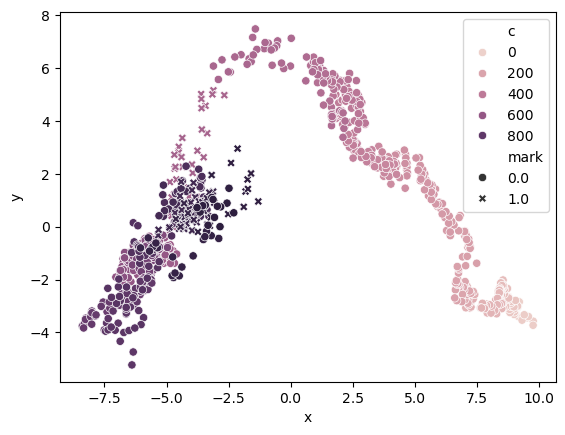

In [20]:
# Make Figure
x = features[:,0]
y = features[:,1]
c = np.arange(0, 1000)
mark = infer_rewards[TRAJECTORY_TO_DRAW]
# print(mark)
df = pd.DataFrame({'x':x,'y':y,'c':c, 'mark':mark})
scatter_plot = sns.scatterplot(data = df, x='x', y='y', hue='c', style='mark')

scatter_fig = scatter_plot.get_figure()
scatter_fig.savefig('scatterplot_inferred_goal.png')

# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

# plt.scatter(features[:1000,0], features[:1000,1], c=np.arange(0, 1000))
# # plt.scatter(features[1000:,0], features[1000:,1], c='0')
# plt.colorbar(label="timestep")
# plt.title(f"Trajectory{TRAJECTORY_TO_DRAW} (s,a) embeddings, {args.env_name}, {CKPT_NAME}")
# plt.savefig("pca.png")

print("total reward with inferred goal", np.sum(infer_rewards[TRAJECTORY_TO_DRAW]))

total reward with true goal 13.0


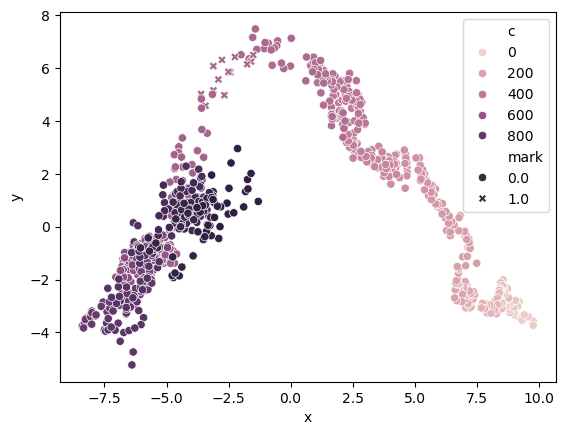

In [21]:
# Make Figure
x = features[:,0]
y = features[:,1]
c = np.arange(0, 1000)
mark = infer_true_successes[TRAJECTORY_TO_DRAW]
# print(mark)
df = pd.DataFrame({'x':x,'y':y,'c':c, 'mark':mark})
scatter_plot = sns.scatterplot(data = df, x='x', y='y', hue='c', style='mark')

scatter_fig = scatter_plot.get_figure()
scatter_fig.savefig('scatterplot_inferred_goal.png')

# fig = swarm_plot.get_figure()
# fig.savefig("out.png") 

# plt.scatter(features[:1000,0], features[:1000,1], c=np.arange(0, 1000))
# # plt.scatter(features[1000:,0], features[1000:,1], c='0')
# plt.colorbar(label="timestep")
# plt.title(f"Trajectory{TRAJECTORY_TO_DRAW} (s,a) embeddings, {args.env_name}, {CKPT_NAME}")
# plt.savefig("pca.png")

print("total reward with true goal", np.sum(infer_true_successes[TRAJECTORY_TO_DRAW]))